# Glass Expert Optimization Example

This notebook demonstrates how to use the `GlassExpert` optimizer in Optiland to optimize an optical system with both continuous (e.g., radii, thicknesses) and categorical (glass types) variables.

In [1]:
import optiland.backend as be
from optiland import optic, optimization
from optiland.materials import glasses_selection

## 1. Define the Optical System

We'll use a simple Cooke Triplet as the starting point for our optimization.

╒════╤═════════════════╤═══════════╤══════════╤═════════════╤════════════╤═════════╤═════════════════╕
│    │ Type            │ Comment   │   Radius │   Thickness │ Material   │   Conic │   Semi-aperture │
╞════╪═════════════════╪═══════════╪══════════╪═════════════╪════════════╪═════════╪═════════════════╡
│  0 │ Planar          │           │      inf │       inf   │ Air        │       0 │         7.04289 │
│  1 │ Standard        │           │       25 │         2.5 │ N-BK7      │       0 │         7.04289 │
│  2 │ Standard        │           │     -150 │         7.5 │ Air        │       0 │         6.5123  │
│  3 │ Stop - Standard │           │      -25 │         1.5 │ N-F2       │       0 │         3.92965 │
│  4 │ Standard        │           │       25 │         5   │ Air        │       0 │         4.11651 │
│  5 │ Standard        │           │      150 │         2.5 │ N-BK7      │       0 │         5.63609 │
│  6 │ Standard        │           │      -25 │        40   │ Air        

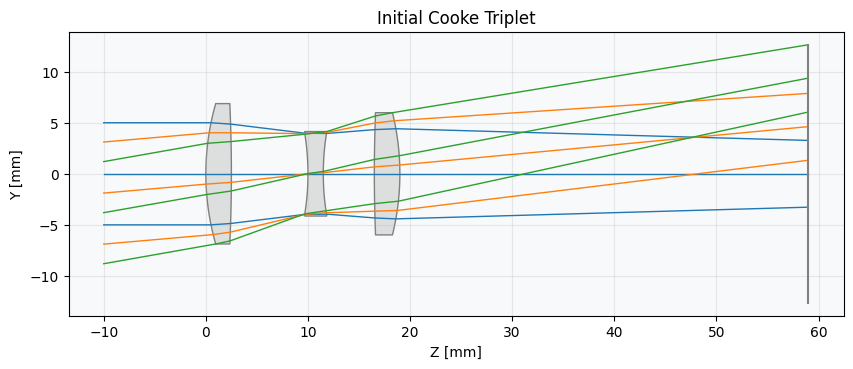

In [2]:
class CookeTripletStartPoint(optic.Optic):
    def __init__(self):
        super().__init__()
        self.add_surface(index=0, radius=be.inf, thickness=be.inf)  # Object surface
        self.add_surface(index=1, radius=25.0, thickness=2.5, material="N-BK7")
        self.add_surface(index=2, radius=-150.0, thickness=7.5)
        self.add_surface(
            index=3, radius=-25.0, thickness=1.5, material="N-F2", is_stop=True
        )  # Stop surface
        self.add_surface(index=4, radius=25.0, thickness=5.0)
        self.add_surface(index=5, radius=150.0, thickness=2.5, material="N-BK7")
        self.add_surface(index=6, radius=-25.0, thickness=40.0)
        self.add_surface(index=7)  # Image surface

        self.set_aperture(aperture_type="EPD", value=10)
        self.set_field_type(field_type="angle")
        self.add_field(y=0)
        self.add_field(y=5)
        self.add_field(y=10)

        self.add_wavelength(value=0.4861)  # F
        self.add_wavelength(value=0.5876, is_primary=True)  # d
        self.add_wavelength(value=0.6563)  # C


lens_system = CookeTripletStartPoint()

# Display initial lens
lens_system.draw(title="Initial Cooke Triplet")
lens_system.info()

## 2. Define the Optimization Problem

We'll set up operands to minimize RMS spot size and maintain a target focal length. Variables will include radii, thicknesses, and the materials of the lenses.

In [ ]:
problem = optimization.OptimizationProblem()
target_focal_length = 50.0

# Operand: Effective Focal Length (EFL)
problem.add_operand(
    input_data={"optic": lens_system},
    operand_type="f2",
    target=target_focal_length,
    weight=1.0,
)

# Operands: RMS Spot Size for each field
for Hx, Hy in lens_system.fields.get_field_coords():
    problem.add_operand(
        operand_type="rms_spot_size",
        target=0.0,
        weight=10.0,
        input_data={
            "optic": lens_system,
            "surface_number": -1,  # Image surface
            "Hx": Hx,
            "Hy": Hy,
            "num_rays": 16,  # Rays on one axis for 'uniform' distribution
            "wavelength": lens_system.primary_wavelength,
            "distribution": "uniform",
        },
    )

# Variables: Radii
problem.add_variable(lens_system, "radius", surface_number=1, min_val=10, max_val=100)
problem.add_variable(lens_system, "radius", surface_number=2, min_val=-200, max_val=-20)
problem.add_variable(lens_system, "radius", surface_number=3, min_val=-100, max_val=-10)
problem.add_variable(lens_system, "radius", surface_number=4, min_val=10, max_val=100)
problem.add_variable(lens_system, "radius", surface_number=5, min_val=20, max_val=200)
problem.add_variable(lens_system, "radius", surface_number=6, min_val=-100, max_val=-10)

# Variables: Thicknesses (air and glass)
problem.add_variable(lens_system, "thickness", surface_number=1, min_val=1, max_val=5)  # Lens 1 thickness
problem.add_variable(lens_system, "thickness", surface_number=2, min_val=1, max_val=15)  # Air space 1
problem.add_variable(lens_system, "thickness", surface_number=3, min_val=1, max_val=5)  # Lens 2 thickness
problem.add_variable(lens_system, "thickness", surface_number=4, min_val=1, max_val=15)  # Air space 2
problem.add_variable(lens_system, "thickness", surface_number=5, min_val=1, max_val=5)  # Lens 3 thickness
problem.add_variable(lens_system, "thickness", surface_number=6, min_val=30, max_val=60)  # Back focal length (approx)

# Variables: Materials (using Glass Expert)
available_glasses = glasses_selection(lambda_min=0.4, lambda_max=0.7, catalogs=["schott", "ohara_common"])
problem.add_variable(lens_system, "material", surface_number=1, glass_selection=available_glasses)
problem.add_variable(lens_system, "material", surface_number=3, glass_selection=available_glasses)
problem.add_variable(lens_system, "material", surface_number=5, glass_selection=available_glasses)

problem.info()

╒════╤════════════════════════╤═══════════════════╕
│    │   Merit Function Value │   Improvement (%) │
╞════╪════════════════════════╪═══════════════════╡
│  0 │                14065.2 │                 0 │
╘════╧════════════════════════╧═══════════════════╛
╒════╤════════════════╤══════════╤══════════════╤══════════════╤══════════╤═════════╤═════════╤════════════════╕
│    │ Operand Type   │   Target │ Min. Bound   │ Max. Bound   │   Weight │   Value │   Delta │   Contrib. [%] │
╞════╪════════════════╪══════════╪══════════════╪══════════════╪══════════╪═════════╪═════════╪════════════════╡
│  0 │ f2             │       50 │              │              │        1 │ 161.994 │ 111.994 │          89.18 │
│  1 │ rms spot size  │        0 │              │              │       10 │   2.249 │   2.249 │           3.59 │
│  2 │ rms spot size  │        0 │              │              │       10 │   2.251 │   2.251 │           3.6  │
│  3 │ rms spot size  │        0 │              │             

## 3. Run the Glass Expert Optimization

Initial error function value: 14065.2
Initial glasses combination: ['N-BK7', 'N-F2', 'N-BK7']

----------------------------------------------------------------------
Global exploration

Selecting Material, Surface 1:
	Trying N-SF11   as Material, Surface 1. Error function value: 0.00
	Trying BOROFLOAT33 as Material, Surface 1. WARNING: No extinction coefficient data found for BOROFLOAT33.yml. Assuming it is 0.
Error function value: 0.23
	Trying N-LAK34  as Material, Surface 1. Error function value: 0.00
	Trying N-BAF4   as Material, Surface 1. Error function value: 0.01
	Trying N-FK51   as Material, Surface 1. Error function value: 0.17
	Trying N-SF2    as Material, Surface 1. Error function value: 0.00
	Trying AF32ECO  as Material, Surface 1. Error function value: 0.18
	-> Selected N-LAK34 as Material, Surface 1.
	New combination: ['N-LAK34', 'N-F2', 'N-BK7']
	Best error function value: 0.00 (-100%).

Selecting Material, Surface 3:
	Trying N-SF11   as Material, Surface 3. Error functi

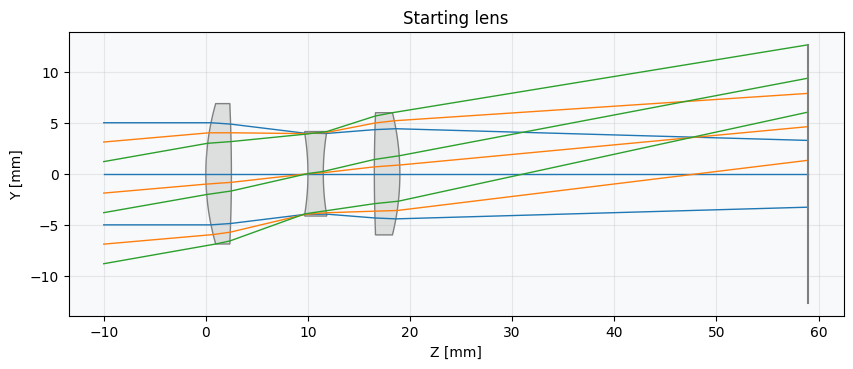

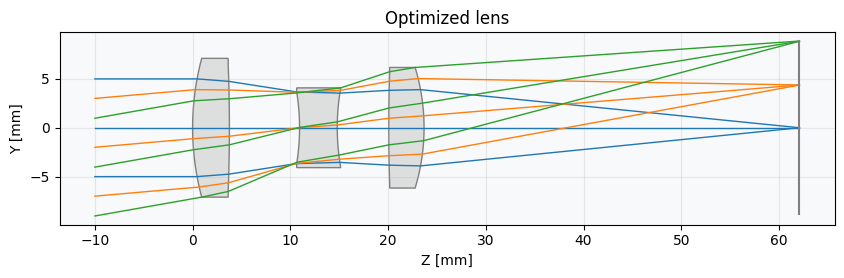

In [4]:
optimizer = optimization.GlassExpert(problem)

# Draw the starting lens
lens_system.draw(title="Starting lens")
print(f"Initial error function value: {problem.initial_value:.1f}")

# Run optimization
res = optimizer.run(
    num_neighbours=7,
    maxiter=100,
    tol=1e-6,
    verbose=True,
    plot_glass_map=False,
)

# Display the optimized lens
lens_system.draw(title="Optimized lens")
lens_system.info()